<img src = "https://drive.google.com/uc?export=view&id=1O_GIqeNM4LCwbcoN9tVKHbW3UR_N9yDu">

# Thesis: Segmentation of Electron Microscopy Kidney Biopsy Images
<b>Name</b>: Aristotelis Styanidis |
<b>Date</b>: January 2023
---
This document is structured as follows:
* [Importing packages](#Importing-packages)
* [I. Loading Data](#I.-Loading-Data) 
* [II. Data Preprocessing](#II.-Data-Preprocessing)
* [III. Dataset and DataLoader](#III.-Dataset-and-DataLoader)
* [IV. The Model](#IV.-The-Model)
* [V. Loss function and Optimizer](#V.-Loss-function-and-Optimizer)
* [VI. Saving the model](#VI.-Saving-the-model)
* [VII. Training and evaluating the model](#VII.-Training-and-evaluating-the-model)
* [VIII. Testing the model on the test data](#VIII.-Testing-the-model-on-the-test-data)
* [IX. Results](#IX.-Results)

This template notebook demonstrates the required steps in order to train and evaluate a U-Net model. 

## Importing packages
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)

In [1]:
from cgi import test
import time
import enum
from json import load
from operator import index
import os
from cv2 import imshow
from matplotlib import image 
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate, Transpose, GaussNoise
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from model import build_unet

In [3]:
import time
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import KFold, train_test_split
import torch
from torch.utils.data import DataLoader

from utils import epoch_time, get_image_names, get_paths, seeding, rgb2mask
from model import build_unet
import albumentations as A
from loss import DiceLoss, DiceBCELoss, CELoss
from data import CustomDataset

import pandas as pd

In [4]:
# 0: background, 1: podocytes, 2: gbm
LABEL_TO_COLOR = {0:[0,0,0], 1:[0,255,0], 2:[255,0,0]}

## I. Loading Data
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)

In [5]:
""" Seeding """
seeding(42)

""" Loading the original images and masks """
path = "../dataset"

images = np.array(sorted(glob(os.path.join(path, "images", "*.tif"))))
masks = np.array(sorted(glob(os.path.join(path, "masks_rgb", "*.png"))))

print(f"Number of Images: {len(images)}")
print(f"Number of RGB Masks: {len(masks)}")

Number of Images: 10
Number of RGB Masks: 10


## II. Data Preprocessing
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)

In [6]:
""" Cropping the image on the x-axis """
def crop_image(img, x_min, x_max):
    cropped_img = img[:, x_min:x_max]
    return cropped_img

In [7]:
""" Creating and saving patches to a new directory """
def create_patches(images, masks, save_path, patch_size = 512):
    size = (3584, 3072)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        
        """ Extracting the name """
        name = x.split("/")[-1].split("\\")[-1].split(".")[0]

        """ Reading Image and Mask """
        # Reads image as a grayscale image
        x = cv.imread(x, 0)
        
        # Reads mask as a rgb image
        y = cv.imread(y, 1)
        
        
        """ Cropping Image """
        # Crops the image in order to fit 
        # with the Unet input dimensions
        crop_image(x, 128, 3712)
        crop_image(y, 128, 3712)

        
        i_patches = patchify(x, (patch_size, patch_size), step=patch_size)
        m_patches = patchify(y, (patch_size, patch_size, 3), step=patch_size)

        """ Spliting image into patches """
        for k in range(i_patches.shape[0]):
            for l in range(i_patches.shape[1]):
                tmp_image_name = f"{name}" + "_" + str(k) + "_" + str(l) + ".png"
                tmp_mask_name = f"{name}" + "_" + str(k) + "_" + str(l) + " - rgb_mask.png"

                image_path = os.path.join(save_path, "images", tmp_image_name)
                mask_path = os.path.join(save_path, "masks", tmp_mask_name)

                cv.imwrite(image_path, i_patches[k, l, :, :])
                cv.imwrite(mask_path, m_patches[k, l, 0, :, :,:])

In [8]:
# Uncomment to create and save the patches
# create_patches(images_paths, masks_paths, "C:/Users/Aristotelis/src/Thesis_src/dataset_patches")

In [9]:
""" Loading the image and mask patches """
path = "../dataset_patches"

image_patches = np.array(sorted(glob(os.path.join(path, "images", "*.png"))))
mask_patches = np.array(sorted(glob(os.path.join(path, "masks", "*.png"))))

print(f"Number of image patches: {len(image_patches)}")
print(f"Number of rgb mask patches: {len(mask_patches)}")

Number of image patches: 420
Number of rgb mask patches: 420


### K - Fold Cross Validation

In [10]:
""" K - Fold Split (5 - Fold) """

# prepare cross validation
kfold = KFold(n_splits=5)

i = 0
# enumerate splits
for tmp_train, tmp_test in kfold.split(images):
    train_set, valid_set = train_test_split(tmp_train, test_size=0.3, random_state=17)
    test_set = tmp_test
    print("----------------------------------------------------------")
    print("Fold", i + 1)
    print("Train:", train_set, "Valid:", valid_set, "Test: ", test_set)
    i = i + 1
    # uncomment break in case you want to run only for one fold
    if i == 5:
        break

----------------------------------------------------------
Fold 1
Train: [7 2 8 3 9] Valid: [6 5 4] Test:  [0 1]
----------------------------------------------------------
Fold 2
Train: [7 0 8 1 9] Valid: [6 5 4] Test:  [2 3]
----------------------------------------------------------
Fold 3
Train: [7 0 8 1 9] Valid: [6 3 2] Test:  [4 5]
----------------------------------------------------------
Fold 4
Train: [5 0 8 1 9] Valid: [4 3 2] Test:  [6 7]
----------------------------------------------------------
Fold 5
Train: [5 0 6 1 7] Valid: [4 3 2] Test:  [8 9]


In [11]:
print(images[test_set])

['../dataset\\images\\20B794  foto 12  3000x.tif'
 '../dataset\\images\\20B9593  foto 1  3000x.tif']


In [12]:
train_images = get_image_names(images, train_set)
valid_images = get_image_names(images, valid_set)
test_images = get_image_names(images, test_set)

In [13]:
print("Train Images:\n", train_images)
print("Validation Images:\n", valid_images)
print("Test Images:\n", test_images)

Train Images:
 ['20B6215  foto 11  3000x', '20B10793  foto 14  3000x', '20B6494  foto 4  3000x', '20B13170  foto 3  3000x', '20B6652  foto 2  3000x']
Validation Images:
 ['20B5822  foto 13  3000x', '20B5020  foto 12  3000x', '20B3318  foto 2  3000x']
Test Images:
 ['20B794  foto 12  3000x', '20B9593  foto 1  3000x']


In [14]:
train_img_patches, train_mask_patches = get_paths(image_patches, mask_patches, train_images)
valid_img_patches, valid_mask_patches = get_paths(image_patches, mask_patches, valid_images)
test_img_patches, test_mask_patches = get_paths(image_patches, mask_patches, test_images)

## III. Dataset and DataLoader
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)

In [15]:
train_transform = A.Compose(
        [
            A.Rotate(limit=45, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.GaussNoise(p=0.5)
        ]
    )

In [16]:
train_dataset = CustomDataset(train_img_patches, train_mask_patches, transform = train_transform)
valid_dataset = CustomDataset(valid_img_patches, valid_mask_patches, transform = None)
test_dataset = CustomDataset(test_img_patches, test_mask_patches, transform = None)

In [17]:
print("Train patches:", len(train_dataset))
print("Valid patches:", len(valid_dataset))
print("Test patches:", len(test_dataset))

Train patches: 840
Valid patches: 126
Test patches: 84


In [18]:
""" Hyperparameters """
batch_size = 2
num_epochs = 50
lr = 1e-6

In [19]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1
    )

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1
    )

In [20]:
# Sanity check
# printing train_loader length
# it has to be len(train_dataset)/batch_size

print(len(train_loader))
print(len(train_dataset)/batch_size)

420
420.0


## IV. The Model
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device used:", device)

Device used: cuda


In [22]:
model = build_unet()
model = model.to(device)

In [23]:
# Uncomment to view model architecture
print("Model Architecture:\n\n", model)

Model Architecture:

 build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPo

## V. Loss function and Optimizer
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)

In [24]:
# Binary Cross Entropy -> Binary Semantic Segmentation
# loss_fn = DiceBCELoss()

# Categorical Cross Entropy -> Multiclass Semantic Segmentation
# loss_fn = DiceLoss()

# Categorical Cross Entropy
loss_fn = CELoss()

# Dealing with the imbalanced dataset
# Caution! CELoss() weight has to be a tensor
# loss_fn = CELoss(weight=[0.45620364, 1.97879363, 3.30427707])

In [25]:
# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=0.1)

# adjusting the learning rate based on the number of epochs by using a scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5, verbose=True)

## VI. Saving the model
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)

In [26]:
# defining the checkpoint path to save the model weights
timestr = time.strftime("%Y_%m_%d_%H_%M_%S_")

str = f"no_dropout_lr_06_kfold_validation_fold_{i}.pth"

checkpoint_path = "files/" + timestr + str

print("Checkpoint path:", checkpoint_path)

# defining a loss file to save the train and validation loss through time
loss_file_name = f"losses/{timestr}no_dropout_lr_06_loss_fold_{i}.csv"

print("Loss file name:", loss_file_name)

Checkpoint path: files/2022_10_19_22_44_59_no_dropout_kfold_validation_fold_5.pth
Loss file name: losses/2022_10_19_22_44_59_no_dropout_loss_fold_5.csv


## VII. Training and evaluating the model
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)

In [27]:
""" Training function to calculate the training epoch loss """
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    
    # indicating that the model is training
    # (important for dropout and batch_norm layers)
    model.train()
    
    # going through all the batches in the loader
    for x, y in loader:
        # loading the images and the corresponding masks to the GPU device
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        
        # setting the gradients to zero
        optimizer.zero_grad()
        
        # making a prediction
        y_pred = model(x)
        
        # finding the loss between the prediction and the ground truth
        loss = loss_fn(y_pred, y)
        
        # performing back propagation
        loss.backward()
        
        # optimizing the loss function using the optimizer
        optimizer.step()
        
        # adding each batch loss to calculate later the average of all batches
        epoch_loss += loss.item()
        
    # calculating the mean loss
    epoch_loss = epoch_loss/len(loader)
    return epoch_loss 

In [28]:
""" Validation function to calculate the validation epoch loss """
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    
    # turn off dropout, batch norm, etc. layers
    # during model evaluation
    model.eval()
    
    # turning off gradients computation
    with torch.no_grad():
        # going through all the batches in the loader
        for x, y in loader:
            # loading the images and the corresponding masks to the GPU device
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            
            # making a prediction
            y_pred = model(x)
            
            # finding the loss between the prediction and the ground truth
            loss = loss_fn(y_pred, y)

            # adding each batch loss to calculate later the average of all batches
            epoch_loss += loss.item()
            
        # calculating the mean loss
        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [29]:
'''
""" Training the model """
# Used as a checkpoint
best_valid_loss = float("inf")

train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)



    """ Saving the model """
    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}"
        print(data_str)

        best_valid_loss = valid_loss

        # Just to save the model
        # torch.save(model.state_dict(), checkpoint_path)

        # Creating a checkpoint to save the best epoch
        # model state dict (weights & biases), optimizer state,
        # training losses and validation losses for printing purpose

        checkpoint = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "valid_losses": valid_losses
        }

        torch.save(checkpoint, checkpoint_path)


    # Scheduler to reduce lr if not improved after a number of epochs
    scheduler.step(valid_loss)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    data_str = f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n"
    data_str += f"\tTrain Loss: {train_loss:.3f}\n"
    data_str += f"\tVal. Loss: {valid_loss:.3f}\n"
    print(data_str)

    # Keep track of the train and validation loss
    # in order to plot them later
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    # dictionary of lists  
    loss_dict = {'train_loss': train_losses, 'val_loss': valid_losses}  

    df = pd.DataFrame(loss_dict) 

    # saving the dataframe 
    df.to_csv(loss_file_name)
'''

'\n""" Training the model """\n# Used as a checkpoint\nbest_valid_loss = float("inf")\n\ntrain_losses = []\nvalid_losses = []\nfor epoch in range(num_epochs):\n    start_time = time.time()\n\n    train_loss = train(model, train_loader, optimizer, loss_fn, device)\n    valid_loss = evaluate(model, valid_loader, loss_fn, device)\n\n\n\n    """ Saving the model """\n    if valid_loss < best_valid_loss:\n        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}"\n        print(data_str)\n\n        best_valid_loss = valid_loss\n\n        # Just to save the model\n        # torch.save(model.state_dict(), checkpoint_path)\n\n        # Creating a checkpoint to save the best epoch\n        # model state dict (weights & biases), optimizer state,\n        # training losses and validation losses for printing purpose\n\n        checkpoint = {\n            "epoch": epoch,\n            "model_state": model.state_dict(),\n            "optim_state": optimizer.state_dict(

## VIII. Testing the model on the test data
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, jaccard_score, precision_score, recall_score, classification_report, cohen_kappa_score
import seaborn as sns

In [31]:
def calculate_metrics(y_true, y_pred):
    
    categories = ["background", "podocytes", "gbm"]
    
    """ Ground truth """
    #y_true = y_true.cpu().numpy()
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    #y_pred = y_pred.cpu().numpy()
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    mean_score_jaccard = jaccard_score(y_true, y_pred, zero_division = 1, average="macro")
    per_class_jaccard = jaccard_score(y_true, y_pred, zero_division = 1, average=None)
    
    mean_score_f1 = f1_score(y_true, y_pred, zero_division = 1, average="macro")
    per_class_f1 = f1_score(y_true, y_pred, zero_division = 1, average=None)

    mean_score_recall = recall_score(y_true, y_pred, zero_division = 1, average="macro")
    per_class_recall = recall_score(y_true, y_pred, zero_division = 1, average=None)

    mean_score_precision = precision_score(y_true, y_pred, zero_division = 1, average="macro")
    per_class_precision = precision_score(y_true, y_pred, zero_division = 1, average=None)

    score_acc = accuracy_score(y_true, y_pred)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    
    '''Calculate confusion matrix '''
    cm = confusion_matrix(y_true, y_pred)

    '''Calculate FP, FN, TP, TN per class '''
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
 
    print("\t\t\t background  podocytes  gbm\n")
    print("mIoU\t\t\t", mean_score_jaccard)
    print("per class IoU\t\t", per_class_jaccard)
    print("\n")
    print("mean f1 score\t\t", mean_score_f1)
    print("per class f1 score\t", per_class_f1)
    print("\n")
    print("mean recall\t\t", mean_score_recall)
    print("per class recall\t", per_class_recall)
    print("\n")
    print("mean TNR\t\t", np.mean(TNR))
    print("per class TNR\t\t", TNR)
    print("\n")
    print("mean precision\t\t", mean_score_precision)
    print("per class precision\t", per_class_precision)
    print("\n")
    print("accuracy\t\t", score_acc)
    print("\n")
    print("cohen's kappa\t\t", kappa)
    
    print("\n")
    print("classification report")
    print(classification_report(y_true, y_pred, target_names=categories))
    
    
    print("confusion matrix:\n")
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # print("True positives per class", TP)
    # print("True negatives per class", TN)
    # print("False positives per class", FP)
    # print("False negatives per class", FN)

    # return [mean_score_jaccard, score_acc]

In [32]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

In [33]:
test_x = images[test_set]
test_y = masks[test_set]

print(test_x)
print(test_y)

['../dataset\\images\\20B794  foto 12  3000x.tif'
 '../dataset\\images\\20B9593  foto 1  3000x.tif']
['../dataset\\masks_rgb\\20B794  foto 12  3000x - rgb_mask.png'
 '../dataset\\masks_rgb\\20B9593  foto 1  3000x - rgb_mask.png']


### Loading the checkpoint file

In [34]:
# loading the checkpoint file from the training process
checκpoint_path = "files/2022_10_17_02_04_37_no_dropout_kfold_validation_fold_5.pth"

In [35]:
""" Load the checkpoint file """
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_unet()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

# Loading the checkpoint 
checkpoint = torch.load(checκpoint_path)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_losses']
valid_loss = checkpoint['valid_losses']

In [36]:
""" UNet Hyperparameters """
H = 512
W = 512
size = (W, H)


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


 20B794  foto 12  3000x


			 background  podocytes  gbm

mIoU			 0.5457539722013399
per class IoU		 [0.74520179 0.43171082 0.46034931]


mean f1 score		 0.695845074541254
per class f1 score	 [0.85400072 0.60306986 0.63046465]


mean recall		 0.7219198573505764
per class recall	 [0.84053618 0.58176375 0.74345964]


mean TNR		 0.8390109810362055
per class TNR		 [0.65693642 0.92710314 0.93299339]


mean precision		 0.6803949434987576
per class precision	 [0.86790365 0.62599589 0.54728529]


accuracy		 0.7861354464576358


cohen's kappa		 0.5195610716078733


classification report
              precision    recall  f1-score   support

  background       0.87      0.84      0.85   8019512
   podocytes       0.63      0.58      0.60   1908792
         gbm       0.55      0.74      0.63   1081744

    accuracy                           0.79  11010048
   macro avg       0.68      0.72      0.70  11010048
weighted avg       0.79      0.79      0.79  11010048

confusion matrix:



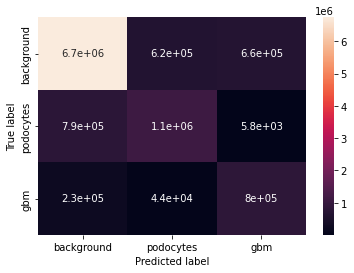


 50%|██████████████████████████████████████████                                          | 1/2 [00:41<00:41, 41.42s/it]


 20B9593  foto 1  3000x


			 background  podocytes  gbm

mIoU			 0.5652411648702964
per class IoU		 [0.81960806 0.23242981 0.64368562]


mean f1 score		 0.6870913455738052
per class f1 score	 [0.9008622  0.37718953 0.78322231]


mean recall		 0.6381516632529269
per class recall	 [0.95858605 0.27651942 0.67934952]


mean TNR		 0.7942773047059916
per class TNR		 [0.42005431 0.96762453 0.99515308]


mean precision		 0.7891370460975263
per class precision	 [0.84969549 0.59312275 0.9245929 ]


accuracy		 0.8366831824893043


cohen's kappa		 0.4729987411852634


classification report
              precision    recall  f1-score   support

  background       0.85      0.96      0.90   8519182
   podocytes       0.59      0.28      0.38   1605182
         gbm       0.92      0.68      0.78    885684

    accuracy                           0.84  11010048
   macro avg       0.79      0.64      0.69  11010048
weighted avg       0.82      0.84      0.82  11010048

confusion matrix:



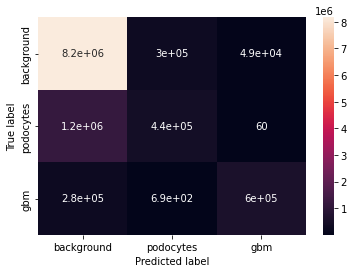

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:17<00:00, 38.61s/it]


In [37]:
model.eval()

metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    """Extract the name """
    name = x.split("/")[-1].split("\\")[-1].split(".")[0]
    print("\n",name)

    ''' Reading image and mask '''
    image = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)

    # Cropping the given image in order to have the right dimensions
    # the following code is actually used only on new images
    if image.shape != (3072, 3584):
        image = image[:, 128:3712]
        mask = mask[:, 128:3712]

    print("\n")
    #print(image.shape)
    #print(mask.shape)


    mask = rgb2mask(mask)
    #print(mask.shape)



    ''' Creating patches of the image and the corresponding mask'''
    patches_x = patchify(image, (512, 512), step=512)
    #print(patches_x.shape)
    patches_y = patchify(mask, (512, 512), step=512)
    #print(patches_y.shape)

    #pred_patches = np.empty(patches_y.shape)
    #print(pred_patches.shape)
    pred_patches = np.empty(patches_x.shape)
    #print(pred_patches.shape)


    for k in range(patches_x.shape[0]):
        for l in range(patches_x.shape[1]):

            x = np.expand_dims(patches_x[k, l, :, :], axis=0)                           # (1, 512, 512) 
            x = x/255.0
            x = np.expand_dims(x, axis=0)                           # (1, 1, 512, 512) to create a batch (egw mallon den to xreiazomai)
            #print("X_shape", x.shape)
            x = x.astype(np.float32)
            x = torch.from_numpy(x)
            x = x.to(device)


            y = np.expand_dims(patches_y[k, l, :, :], axis=0)            # (1, 512, 512)
            #y = np.expand_dims(y, axis=0)               # (1, 1, 512, 512) to create a batch
            y = torch.from_numpy(y)
            y = y.to(device)
            #print(y.shape)

            with torch.no_grad():
                """ Prediction and Calculating FPS """
                start_time = time.time()
                pred_y = model(x)


                # we need a softmax to get a mask as an output
                pred_y = torch.softmax(pred_y, dim=1)
                #print(pred_y.shape)
                pred_y = torch.argmax(pred_y, dim=1)
                #pred_y = np.expand_dims(pred_y, axis=0)
                #print(pred_y.shape)


                total_time = time.time() - start_time
                time_taken.append(total_time)

                #score = calculate_metrics(y, pred_y)
                #metrics_score = list(map(add, metrics_score, score))
                pred_y = pred_y.cpu().numpy()           ## (1, 512, 512)
                #pred_y = pred_y * 255 // 2
                pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
                pred_y = np.array(pred_y, dtype=np.uint8)

                ''' Saving the predicted patch to reconstruct the image at the next step '''
                pred_patches[k, l, :, :] = pred_y


            """ Saving masks """
            # (512, 512) -> (3, 512, 512)
            image_3channel = mask_parse(patches_x[k, l, :, :])
            ori_mask = mask_parse(patches_y[k, l, :, :])
            pred_y = mask_parse(pred_patches[k, l, :, :])
            line = np.ones((size[1], 10, 3)) * 128

            #print(image_3channel.shape, ori_mask.shape, pred_y.shape)


            #print(np.unique(pred_y))

            cat_images = np.concatenate(
                [image_3channel, line, ori_mask * 255 // 2, line, pred_y * 255 // 2], axis=1
            )

            # Creating an image where original image, ground truth and prediction 
            # are side by side to visualize and compare the results
            
            cv2.imwrite(f"results/{name}" + "_" + k.__str__() + "_" + l.__str__() +".png", cat_images)

    reconstructed_image = unpatchify(pred_patches * 255 // 2, image.shape)
    #reconstructed_image = mask_parse(reconstructed_image)
    #print(reconstructed_image.shape)
    cv2.imwrite(f"results_no_patches/{name}.png", reconstructed_image)
    #cv2.imwrite(f"results_no_patches/{name}.png", reconstructed_image)


    pred_mask = unpatchify(pred_patches, image.shape)


    score = calculate_metrics(mask, pred_mask)
    #print(score)

    #break

## IX. Results
[Back](#Thesis:-Segmentation-of-Electron-Microscopy-Kidney-Biopsy-Images)